# Analysis sleep pattern for one person before and after lockdown

Everybody knows that good sleep is an important part of life. Good sleep provides better quality of life, a clear mind, a positive attitude, and more energy for the body.

But what is kind of paraments can we use for understanding and improve our sleep? Can we believe our feels or we need help and a more unbiased point of view?

A while ago, my husband decided to improve his sleep, but if you can’t measure it, you can’t improve it. So he bought a sleep tracking ring.

In this project, I analyze collected data from the sleep tracker and use a simple method and clear visualization to tell a  sleep story. 

__The key questions:__
1. Does he have enough sleep in general.
2. How the lockdown influenced his sleep and activity?
3. Is there a correlation between metrics? 

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from pylab import rcParams
from matplotlib import dates

from matplotlib.dates import AutoDateLocator, AutoDateFormatter, date2num
from matplotlib.dates import DayLocator, HourLocator

In [3]:
# Setting the plotting theme
sns.set()

# and setting the size of all plots
plt.rcParams['figure.figsize'] = 15, 6

# and setting the colors
color = ["#4b85a8", "#d98100", "#aba597"]

In [4]:
# Load dataset. Set index to date column
df = pd.read_csv("sleeping_tracking_.csv",
                 index_col=["date"],
                 parse_dates=["date"])

In [5]:
# Inspect data
df.head(2)

,weekdays,sleep_starts,sleep_ends,sleep_duration_min,light_sleep_min,rem_sleep_min,deep_sleep_min,readiness,sleep_score,activity_score,steps
date,,,,,,,,,,,
2019-10-10,Thursday,10:43:00 PM,5:40:00 AM,383,201,93,89,84,77,87,7819
2019-10-11,Friday,11:14:00 PM,6:00:00 AM,359,203,51,104,79,69,87,7819


In [6]:
# Examine the index
df.index

DatetimeIndex(['2019-10-10', '2019-10-11', '2019-10-12', '2019-10-13',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-19',
               ...
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19',
               '2021-02-20', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-27', '2021-02-28'],
              dtype='datetime64[ns]', name='date', length=447, freq=None)

In [7]:
# Print data information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 447 entries, 2019-10-10 to 2021-02-28
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   weekdays            447 non-null    object
 1   sleep_starts        447 non-null    object
 2   sleep_ends          447 non-null    object
 3   sleep_duration_min  447 non-null    int64 
 4   light_sleep_min     447 non-null    int64 
 5   rem_sleep_min       447 non-null    int64 
 6   deep_sleep_min      447 non-null    int64 
 7   readiness           447 non-null    int64 
 8   sleep_score         447 non-null    int64 
 9   activity_score      447 non-null    int64 
 10  steps               447 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 41.9+ KB


In [8]:
# Inspect the missing values
df.isna().sum()

weekdays              0
sleep_starts          0
sleep_ends            0
sleep_duration_min    0
light_sleep_min       0
rem_sleep_min         0
deep_sleep_min        0
readiness             0
sleep_score           0
activity_score        0
steps                 0
dtype: int64

#### Here is no missing value. But if it would be a few, I could use fillna() or dropna() methods.

In [9]:
# Print summary statistics
df.describe()

,sleep_duration_min,light_sleep_min,rem_sleep_min,deep_sleep_min,readiness,sleep_score,activity_score,steps
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,440.519016,262.523490,92.228188,85.297539,81.062640,78.454139,80.765101,9463.791946
std,61.399223,48.921863,25.341467,22.986320,7.383208,6.496776,8.078418,3246.169685
min,290.000000,128.000000,35.000000,9.000000,51.000000,57.000000,54.000000,1299.000000
25%,403.500000,231.000000,76.000000,70.000000,76.000000,75.000000,76.000000,7447.500000
50%,438.000000,260.000000,90.000000,88.000000,82.000000,79.000000,81.000000,9129.000000
75%,473.000000,291.000000,107.000000,101.000000,87.000000,83.000000,86.500000,11069.000000
max,673.000000,538.000000,189.000000,148.000000,96.000000,94.000000,99.000000,28120.000000


In [10]:
# Analyzed period
delta = df.index[-1]-df.index[0]

print (f" The analyzed data consists of {delta.days} days.")

 The analyzed data consists of 507 days.


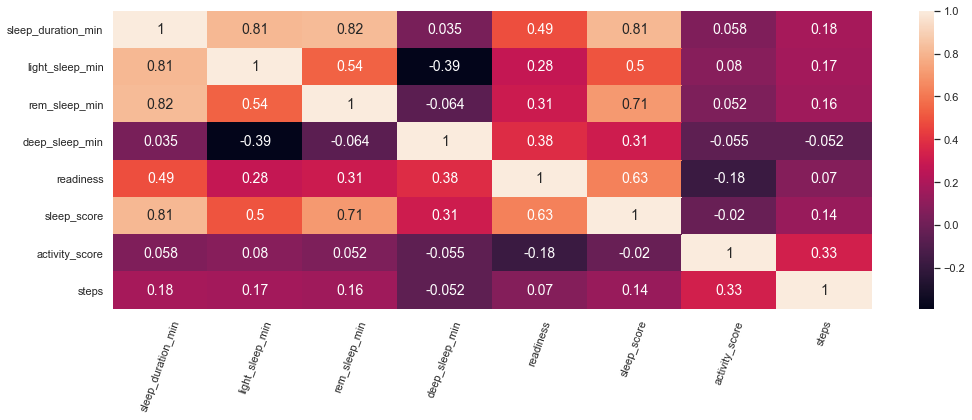

In [11]:
# Get correlation matrix
df_corr = df.corr()

sns.heatmap(df_corr, annot=True, annot_kws={"size": 14})

# Fix ticklabel directions and size
plt.xticks(rotation=70)
plt.yticks(rotation=0)

# Fits plot area to the plot, "tightly"
plt.tight_layout()


##  Does the person have enough sleep?

The sleep range for adults (26-64 years old)  remains __7-9 hours or 420 - 540 minutes__. [How Much Sleep Do We Really Need?](https://www.sleepfoundation.org/press-release/national-sleep-foundation-recommends-new-sleep-times)
\
Also, deep and REM sleep are crucial stages. __REM__ sleep constitutes of __20-25%__ of total sleep. While __deep__ sleep takes __13-23%__ of total sleep

_Sleep duration analysis of REM, deep, light, and total sleep_

In [12]:
def converting_minutes_to_hours(min):
    """Get the minutes and convert to hours and minutes

    Args:
      min (int): The integer, amount of minutes

    Returns:
      int
    """
    h = (min/60)
    m = h-(int(h))
    w = f"{int(h)} hours {int(round(m*60))} min"
    return (w)


In [13]:
def average_sleep_duration(data, column, kind):
    """Get the mean of a column
       and convert the result from minutes to hours and minutes

    Args:
      column (pandas Series): The data to calculate.
      kind (str): The kind of sleep

    Returns:
      str
    """
    # Calculating average sleep duration
    average_sleep_duration_column = data[column].mean()

    # Converting minutes to hours
    a = converting_minutes_to_hours(average_sleep_duration_column)
    # Print average sleep duration

    print (f"Average {kind} sleep is {a}")


In [14]:
# Calculate average duration of sleep for all periods
average_sleep_duration(df, "sleep_duration_min", kind="duration")
average_sleep_duration(df, "deep_sleep_min", kind="deep")
average_sleep_duration(df, "rem_sleep_min", kind="REM")
average_sleep_duration(df, "light_sleep_min", kind="light")


Average duration sleep is 7 hours 21 min
Average deep sleep is 1 hours 25 min
Average REM sleep is 1 hours 32 min
Average light sleep is 4 hours 23 min


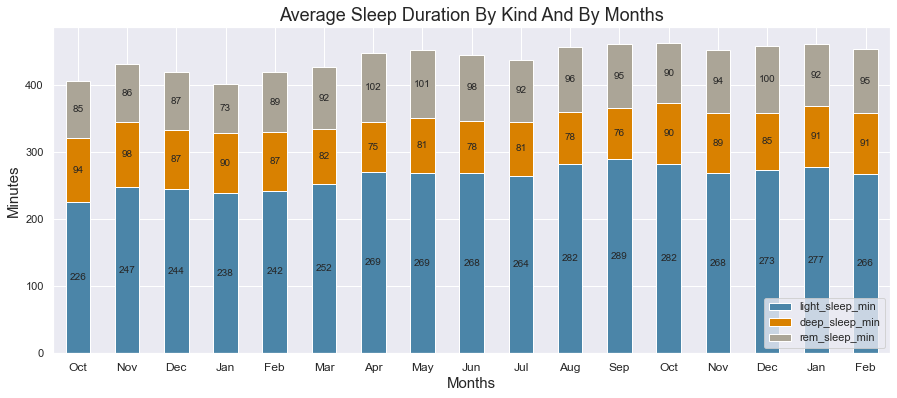

In [15]:
# Plot all kind of sleep average amount in months the df
average_months = df.resample('M').mean()[["light_sleep_min",
                                          "deep_sleep_min",
                                          "rem_sleep_min"]]

ax = average_months.plot.bar(stacked=True, color=color)

# Set labels and legend
ax.set_xticklabels(average_months.index.strftime('%b'),
                   rotation=0,
                   fontsize=12)
ax.set_xlabel('Months', fontsize=15)
ax.set_ylabel('Minutes', fontsize=15)
ax.set_title("Average Sleep Duration By Kind And By Months", fontsize=18)

ax.legend(loc='lower right')
plt.rc('legend', fontsize=13)

# Patches is everything inside of the chart
for rect in ax.patches:
    
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y,
                label_text, ha='center',
                va='center', fontsize=10)


In [16]:
def plot_line(data, xlabel, ylabel, title):
    """Get the data and plot it in lines

    Args:
      data (pandas DataFrame): The data to plot.
      xlabel (str): The label for x axis.
      ylabel (str): The label for y axis.
      title (str): The title for the plot.

    Returns:
      plot
    """

    # Plotting data
    ax = data.plot.line(color=color, grid="white")

    # Set axis labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)

    # Add a red vertical line for pointing when lockdown started
    x = "2020-03-15"
    ax.axvline(x, color="red")
    trans = ax.get_xaxis_transform()
    plt.text(x, .05, 'Lockdown Started', transform=trans)
    ax.axvline(x="2020-03-15", color="red")

    ax.legend(loc='best')
    plt.rc('legend', fontsize=13)

    # Add labels to line plots
    for i, col in data.iteritems():
        for x, y in zip(data.index, col):
            label = "{:.0f}".format(y)
            plt.annotate(label, (x, y),
                         textcoords="offset points",
                         xytext=(10, 10),
                         ha='center')

    plt.show()


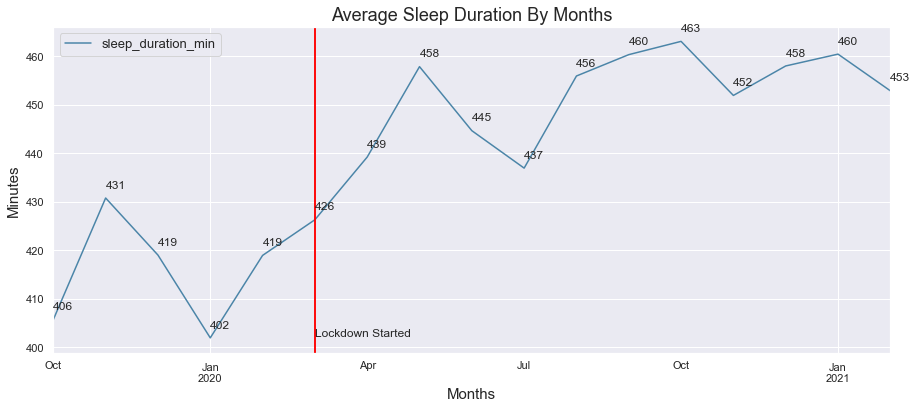

In [17]:
# Resample the average sleep duration to be monthly
sleep_dur_average_monthly = df.resample('M').mean()[['sleep_duration_min']]

# Plot the average sleep duration
plot_line(sleep_dur_average_monthly,
          xlabel="Months", ylabel='Minutes',
          title="Average Sleep Duration By Months")


-----------

_Sleep duration by weekdays before and after lockdown_

In [18]:
# Group the average sleep duration by weekdays
sleep_weekdays = df.groupby('weekdays')[
                 'sleep_duration_min'].mean().sort_values(ascending=False)

# Group the average sleep duration by weekdays before lockdown
sleep_before = df.iloc[lambda x: x.index < "2020-03-15"].groupby(
               'weekdays')['sleep_duration_min'].mean().sort_values(
                ascending=False)

# Group the average sleep duration by weekdays after lockdown
sleep_after = df.iloc[lambda x: x.index > "2020-03-15"].groupby(
              'weekdays')['sleep_duration_min'].mean().sort_values(
               ascending=False)


In [19]:
# Concatenate all dataframes in one
sleep_weekdays_merge = pd.concat([
                         sleep_weekdays,
                         sleep_before,
                         sleep_after], axis=1)

sleep_weekdays_merge = sleep_weekdays_merge.set_axis([
                         'sleep_duration_all_period',
                         'sleep_duration_before_lockdown',
                         'sleep_duration_after_lockdown'],
                          axis='columns')


In [20]:
# Rename column and reset index
sleep_weekdays_merge = sleep_weekdays_merge.rename_axis(
                                   'weekdays').reset_index()


In [21]:
# Check the result of merge
sleep_weekdays_merge

,weekdays,sleep_duration_all_period,sleep_duration_before_lockdown,sleep_duration_after_lockdown
0,Sunday,492.409836,496.777778,494.071429
1,Saturday,470.450000,496.647059,460.093023
2,Friday,440.092308,397.318182,461.976744
3,Thursday,432.016129,409.850000,442.571429
4,Tuesday,421.411765,391.650000,433.812500
5,Wednesday,421.046154,384.650000,437.222222
6,Monday,412.621212,367.428571,433.711111


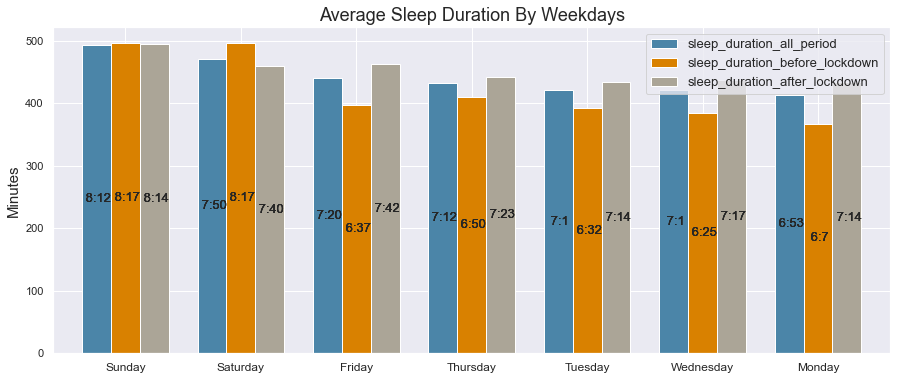

In [22]:
# Plot the average sleep duration by weekdays before and lockdown
ax = sleep_weekdays_merge.plot.bar(color=color, width=0.75)

# Set labels and legend
ax.set_xticklabels(sleep_weekdays_merge.weekdays, rotation=0, fontsize=12)
ax.set_xlabel("", fontsize=15)
ax.set_ylabel("Minutes", fontsize=15)
ax.set_title("Average Sleep Duration By Weekdays", fontsize=18)

ax.legend(loc='best')
plt.rc('legend', fontsize=13)

# Add labels to line plots
for i, col in sleep_weekdays_merge.iteritems():
    # Patches is everything inside of the chart
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
        h = (height/60)
        m = h-(int(h))
        label_text = f" {int(h)}:{int(round(m*60))}"

    # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

    # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y,
                    label_text, ha='center',
                    va='center', fontsize=13)


In [23]:
# Average sleep duration for the entire period
average_sleep = df['sleep_duration_min'].mean()

# Average sleep duration before lockdown
average_sleep_before = df.iloc[lambda x: x.index < "2020-03-15"][
                               'sleep_duration_min'].mean()

# Average sleep duration after lockdown
average_sleep_after = df.iloc[lambda x: x.index > "2020-03-15"][
                               'sleep_duration_min'].mean()

print(f"The average sleep duration for whole time is {int(average_sleep)} min "
      f"or {converting_minutes_to_hours(average_sleep)}. \n"
      f"Before lockdown, the average time was {int(average_sleep_before)} "
      f"or {converting_minutes_to_hours(average_sleep_before)}, \n"
      f"but after lockdown time increased up to {int(average_sleep_after)} min"
      f" or {converting_minutes_to_hours(average_sleep_after)}.")


The average sleep duration for whole time is 440 min or 7 hours 21 min. 
Before lockdown, the average time was 417 or 6 hours 57 min, 
but after lockdown time increased up to 451 min or 7 hours 31 min.


--------------

__Reminder:__  Deep sleep takes __13-23%__ of total sleep.

In [24]:
# Add a new column for the percentage of deep sleep
df["deep_sleep_%"] = round((
                       df["deep_sleep_min"] / df["sleep_duration_min"]) * 100
                       )


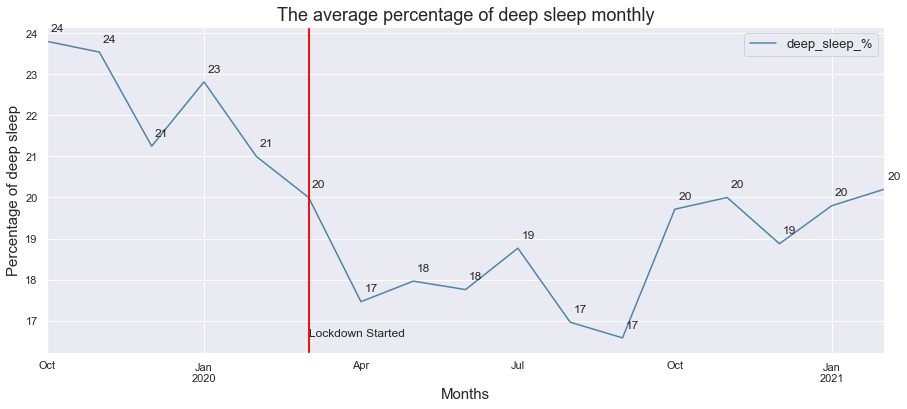

In [25]:
# Resample the percentage of deep sleep to be monthly
average_deep_sleep_months = df.resample('M').mean()[['deep_sleep_%']]

# Plot the average percentage of deep sleep monthly
plot_line(
    average_deep_sleep_months,
    xlabel="Months",
    ylabel="Percentage of deep sleep",
    title="The average percentage of deep sleep monthly"
            )


In [26]:
# The average percentage of deep sleep
average_deep_pct = df['deep_sleep_%'].mean()

# The average percentage of deep sleep before lockdown
average_deep_before_pct = df.iloc[
                           lambda x: x.index < "2020-03-15"][
                           'deep_sleep_%'].mean()

# The average percentage of deep sleep after lockdown
average_deep_after_pct = df.iloc[
                          lambda x: x.index > "2020-03-15"][
                          'deep_sleep_%'].mean()

print(
    f"The average percentage of deep sleep is {int(average_deep_pct)}%.\n"
    f"Before lockdown, percentage was {int(average_deep_before_pct)}%,\n"
    f"but after average percent of deep sleep decreased "
    f"and equaled {int(average_deep_after_pct)}% of total sleep duration."
      )


The average percentage of deep sleep is 19%.
Before lockdown, percentage was 22%,
but after average percent of deep sleep decreased and equaled 18% of total sleep duration.


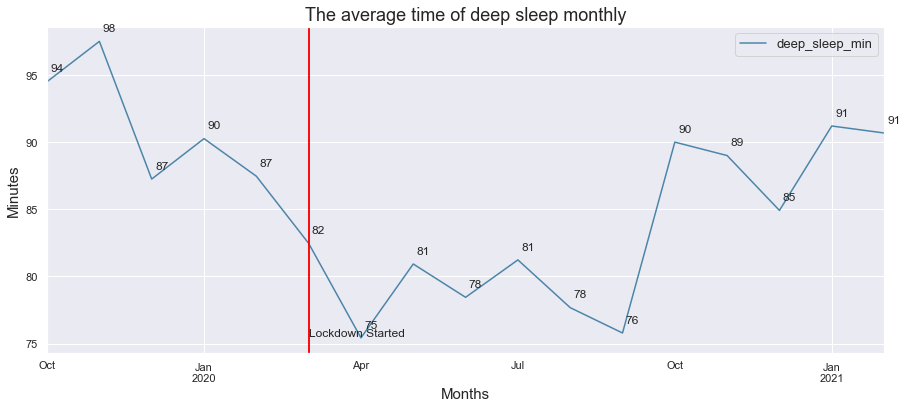

In [27]:
# Resample the time of deep sleep to be monthly
average_deep_sleep_months_min = df.resample('M').mean()[['deep_sleep_min']]

# Plot the average percentage of deep sleep monthly
plot_line(
    average_deep_sleep_months_min,
    xlabel="Months",
    ylabel="Minutes",
    title="The average time of deep sleep monthly"
    )


__Reminder:__ REM sleep takes  __20-25%__ of total sleep.

In [28]:
# Add a new column for the percentage of REM sleep
df["rem_sleep_%"] = round((df["rem_sleep_min"]/df["sleep_duration_min"])*100)


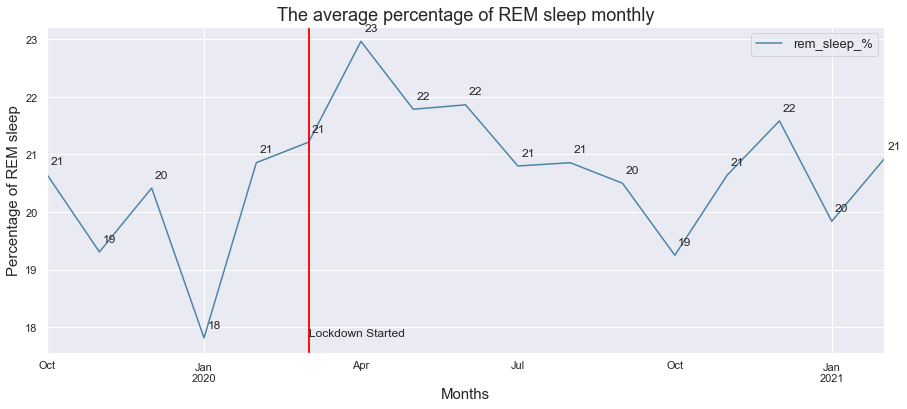

In [29]:
# Resample the percentage of REM sleep to be monthly
average_rem_sleep_months = df.resample('M').mean()[['rem_sleep_%']]

# Plot the average percentage of REM sleep monthly
ax = plot_line(
      average_rem_sleep_months,
      xlabel="Months",
      ylabel="Percentage of REM sleep",
      title="The average percentage of REM sleep monthly"
      )


In [30]:
# The average percentage of REM sleep
average_rem_pct = df['rem_sleep_%'].mean()

# The average percentage of REM sleep before lockdown
average_rem_before_pct = df.iloc[
                           lambda x: x.index < "2020-03-15"][
                           'rem_sleep_%'].mean()

# The average percentage of REM sleep after lockdown
average_rem_after_pct = df.iloc[
                          lambda x: x.index > "2020-03-15"][
                          'rem_sleep_%'].mean()

print(
    f"The average percentage of REM sleep is {int(average_rem_pct)}%. "
    f"Before lockdown, the average percentage was "
    f"{int(average_rem_before_pct)}%,\n"
    f"but after lockdown average percent of REM sleep increased to "
    f"{int(average_rem_after_pct)}%"
    f" of total sleep.")


The average percentage of REM sleep is 20%. Before lockdown, the average percentage was 19%,
but after lockdown average percent of REM sleep increased to 21% of total sleep.


--------------

### Bed time routine

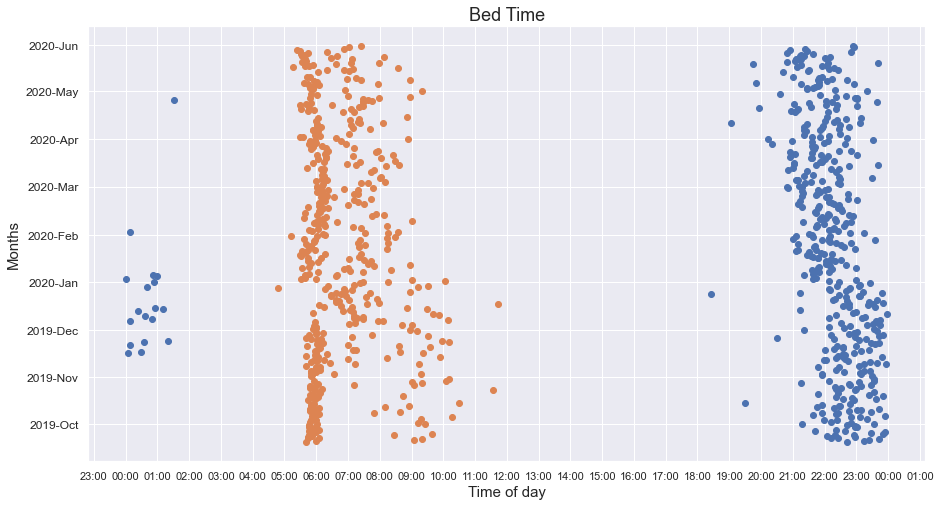

In [31]:
start_of_sleep = mdates.datestr2num(df["sleep_starts"])
end_of_sleep = mdates.datestr2num(df["sleep_ends"])

# plot
fig, ax = plt.subplots(figsize=(15, 8))

plt.plot_date(start_of_sleep, df.index)
plt.plot_date(end_of_sleep, df.index)

# Set the format of the major x-ticks:
majorFmt = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(HourLocator())
ax.xaxis.set_major_formatter(majorFmt)

# Set labels and legend
months = pd.date_range(
           start=df.index[0], end=df.index[-1], freq='M'
           ).strftime('%Y-%b')

ax.set_yticklabels(months, rotation=0, fontsize=12)
ax.set_xlabel("Time of day", fontsize=15)
ax.set_ylabel("Months", fontsize=15)
ax.set_title("Bed Time", fontsize=18)

plt.show()


----------

_Analysis of sleep score, activity score, and readiness_

In [32]:
def plotting_distplots(data):
    """Get the data and plot distplot with median and mean

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.


    Returns:
      distplot
    """
    # Initalize a figure and axes
    fig, axes = plt.subplots(ncols=3, nrows=1)

    # Plot the data
    for i, col in enumerate(data.columns):
        sns.distplot(data[col], ax=axes[i])
        
        axes[i].axvline(
              x=df[col].median(),
              color="#d98100",
              label="Median: " + str(int(df[col].median())),
              linestyle='--', linewidth=2
              )

        axes[i].axvline(
              x=df[col].mean(), color="#d98100",
              label="Mean: " + str(int(df[col].mean())),
              linestyle='-',
              linewidth=2
              )

        axes[i].legend()

    plt.show()


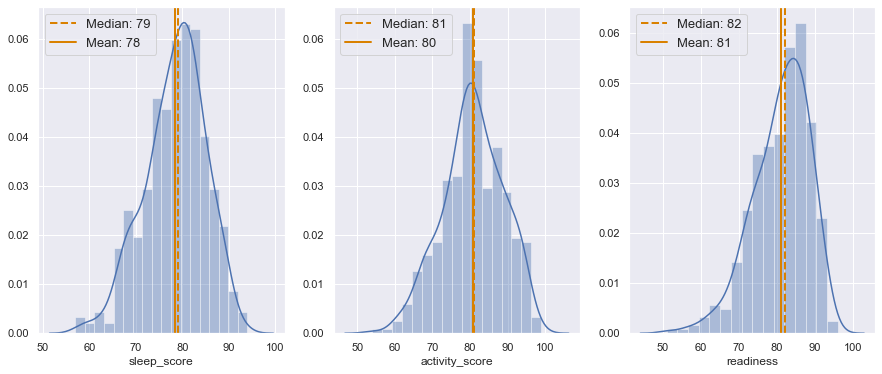

In [33]:
# Plot displots for sleep, activity and readiness scores
plotting_distplots(df[["sleep_score", "activity_score", "readiness"]])


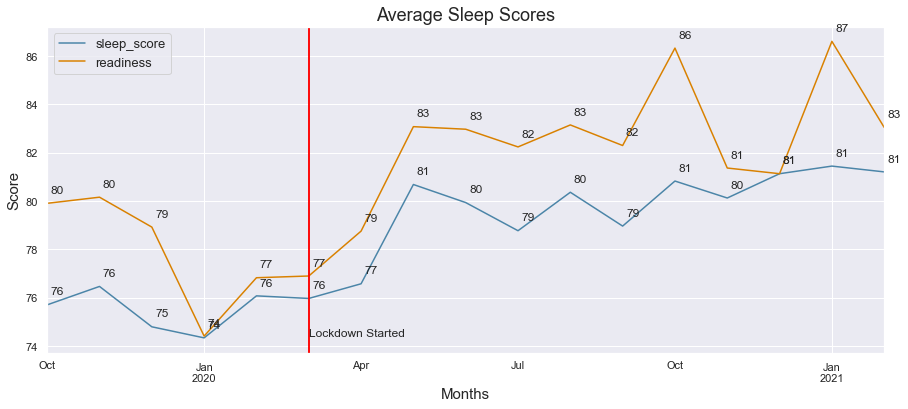

In [34]:
# Resample the average scores and readiness to be monthly
scores_average = df.resample('M').mean()[["sleep_score", "readiness"]]

# Plot the average scores lines plot
plot_line(
    scores_average,
    xlabel="Months",
    ylabel="Score",
    title="Average Sleep Scores"
    )


In [35]:
# The average sleep score
average_sleep_score = df['sleep_score'].mean()

# The average sleep score before lockdown
average_sleep_score_before = df.iloc[
                              lambda x: x.index < "2020-03-15"][
                              'sleep_score'].mean()

# The average sleep score after lockdown
average_sleep_score_after = df.iloc[
                             lambda x: x.index > "2020-03-15"][
                             'sleep_score'].mean()

print(
    f"The average sleep score is {int(average_sleep_score)}%. \n"
    f"Before lockdown, the average sleep score was "
    f"{int(average_sleep_score_before)}%. \n"
    f"But after lockdown average sleep score increased up to "
    f"{int(average_sleep_score_after)}%."
    )


The average sleep score is 78%. 
Before lockdown, the average sleep score was 75%. 
But after lockdown average sleep score increased up to 79%.


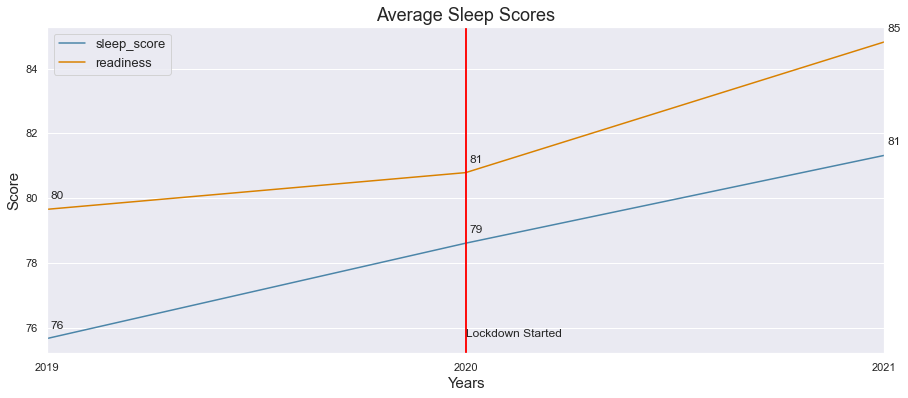

In [36]:
# Resample the average scores to be yearly
scores_by_years = df.resample('Y').mean()[["sleep_score", "readiness"]]

# Plot average sleep score
plot_line(
    scores_by_years,
    xlabel="Years",
    ylabel="Score",
    title="Average Sleep Scores"
    )


In [37]:
def plot_bar(data, xlabel, ylabel, title, period):
    """Get the data and plot vertical bars

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.
      xlabel (str): The label for x axis.
      ylabel (str): The label for y axis.
      title (str): The title for the plot.
      period (strftime) : The period of time


    Returns:
      plot bars
    """
    # Plotting data
    ax = data.plot.bar(color=color)

    # Set labels and legend
    ax.set_xticklabels(data.index.strftime(period), rotation=0, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)

    ax.legend(loc='best')
    plt.rc('legend', fontsize=13)

    # Patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.0f}'

        # ax.text(x, y, text)
        label_x = x + width/2
        label_y = y + height/2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(
                label_x,
                label_y,
                label_text,
                ha='center',
                va='center',
                fontsize=13
                )


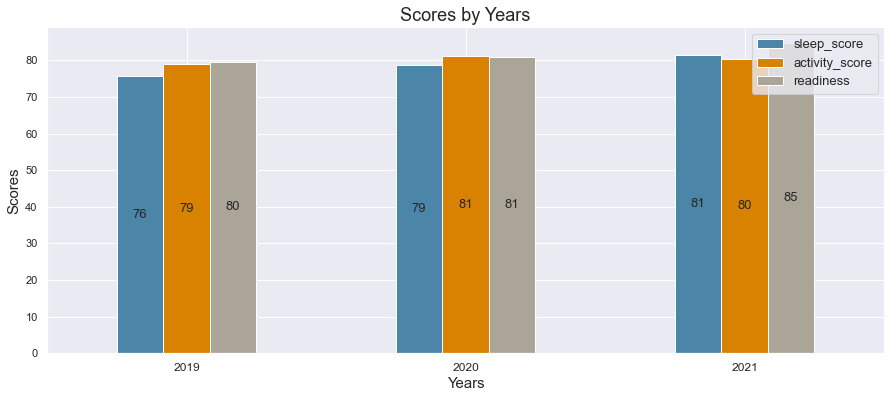

In [38]:
# Resample the average score to be yearly
scores_by_years = df.resample('Y').mean()[[
                                  'sleep_score',
                                  'activity_score',
                                  'readiness'
                                  ]]

# Plot scores by years
plot_bar(
    scores_by_years,
    xlabel='Years', ylabel="Scores",
    title="Scores by Years", period="%Y"
    )


---------

_Analysis activity score and amount of steps_

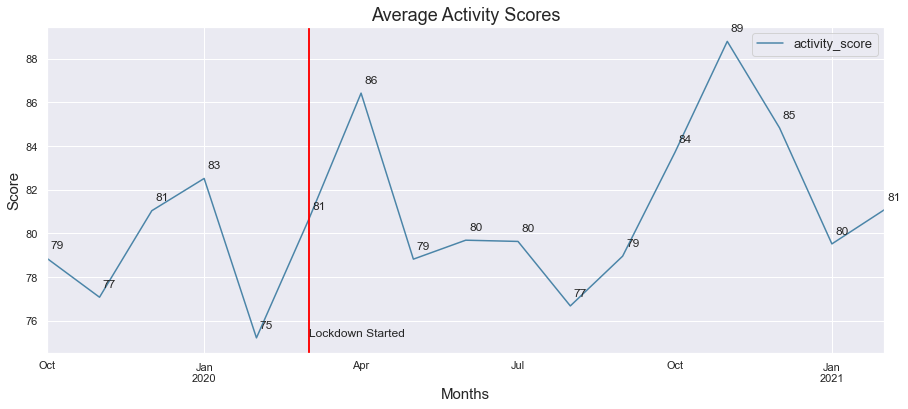

In [39]:
# Resample the average activity score to be monthly
average_activity_score = df.resample('M').mean()[['activity_score']]

# Plot the average activity score by line plot
plot_line(
    average_activity_score,
    xlabel="Months", ylabel="Score",
    title="Average Activity Scores"
    )


In [40]:
average_activity_score_all = df['activity_score'].mean()

average_activity_score_before_lockdown = df.iloc[lambda x: x.index < "2020-03-15"]['activity_score'].mean()

average_activity_score_after_lockdown = df.iloc[lambda x: x.index > "2020-03-15"]['activity_score'].mean()

print(f"The average activity score for whole period is {int(average_activity_score_all)}%. \n"
      f"Before lockdown, the average activity duration was {int(average_activity_score_before_lockdown)}%. \n"
      f"But after lockdown average activity score increased up to {int(average_activity_score_after_lockdown)}%.")

The average activity score for whole period is 80%. 
Before lockdown, the average activity duration was 78%. 
But after lockdown average activity score increased up to 81%.


In [41]:
# Calculating average steps a day 
average_steps = df["steps"].mean()

print (f"Average daily steps are {int(average_steps)}.")

Average daily steps are 9463.


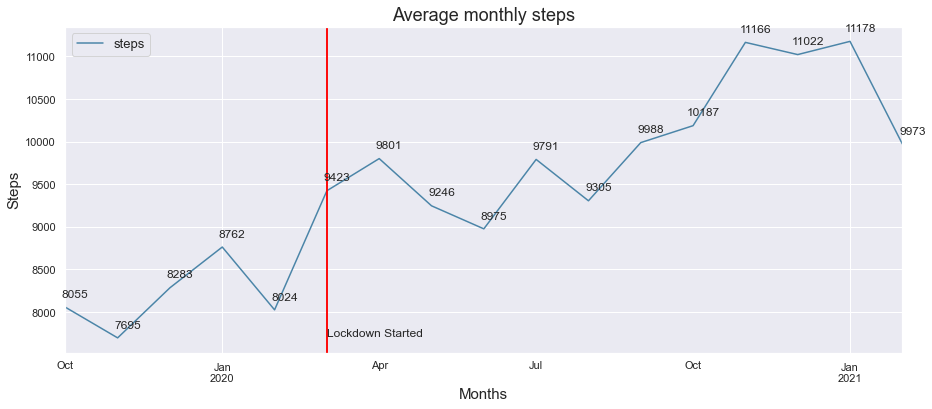

In [42]:
# Plot average steps in months
average_steps_by_months = df.resample('M').mean()[['steps']]

# Use plot_line function for plotting 
plot_line(average_steps_by_months, xlabel = "Months", ylabel = "Steps", title = "Average monthly steps")

In [43]:
# The average steps daily
average_steps = df['steps'].mean()

# The average steps before lockdown daily
average_steps_before = df.iloc[
                         lambda x: x.index < "2020-03-15"][
                         'steps'].mean()

# The average steps after lockdown daily
average_steps_after = df.iloc[
                         lambda x: x.index > "2020-03-15"][
                         'steps'].mean()

print(f"The average daily steps are {int(average_steps)} steps. \n"
      f"Before lockdown, the average steps were "
      f"{int(average_steps_before)} steps. \n"
      f"But after lockdown average steps increased up to "
      f"{int(average_steps_after)} steps.")


The average daily steps are 9463 steps. 
Before lockdown, the average steps were 8151 steps. 
But after lockdown average steps increased up to 10029 steps.


In [44]:
def plot_barh(data, ylabel, xlabel, title):
    """Get the data and plot horizontal bars with labels

    Args:
      data (pandas DataFrame): The DataFrame with specific columns to plot.
      xlabel (str): The label for x axis.
      ylabel (str): The label for y axis.
      title (str): The title for the plot.


    Returns:
      plot horizontal bars
    """

    ax, fig = plt.subplots()

    ax = data.plot(kind="barh", color=["#4b85a8"])

    # Set axis labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)

    ax.legend(loc='best')
    plt.rc('legend', fontsize=13)

    for i, v in enumerate(data):
        w = f" {int(v)}  steps"
        ax.text((v + 5)/30, i-0.07, str(w), color='black', fontsize=15)


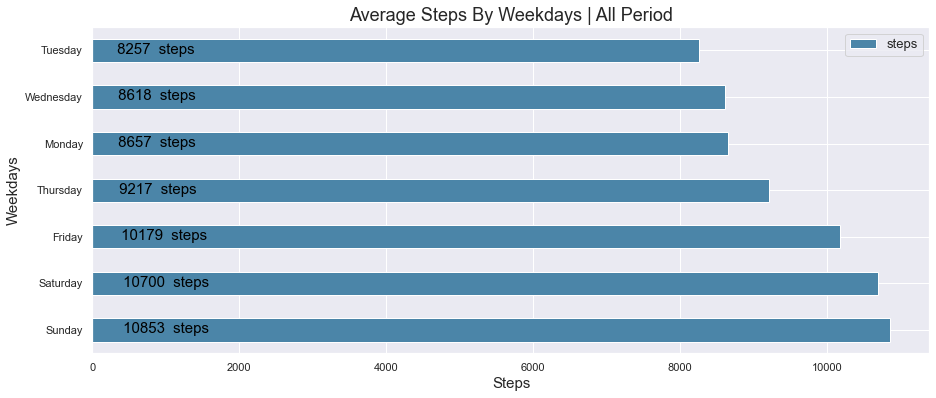

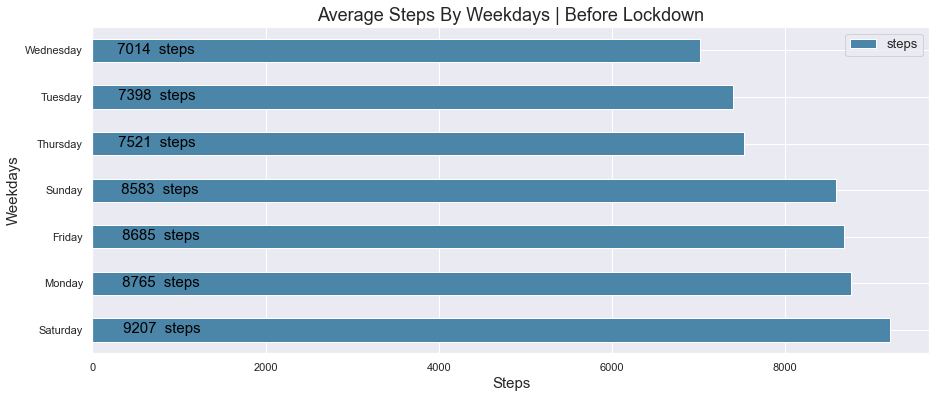

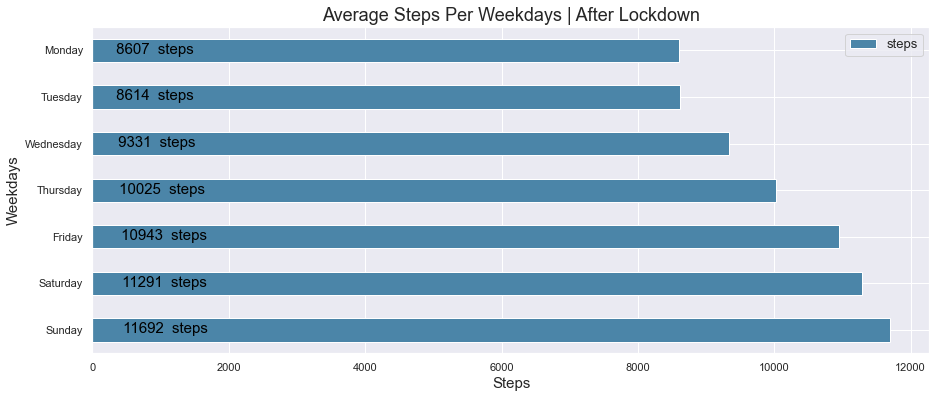

In [45]:
# Group the average steps amount by weekdays
steps_by_weekdays = df.groupby(
                      'weekdays')['steps'].mean().sort_values(
                       ascending=False
                       )
# Plot steps_by_weekdays
plot_barh(
    steps_by_weekdays,
    ylabel="Weekdays", xlabel="Steps",
    title="Average Steps By Weekdays | All Period"
    )

# Group the average steps amount by weekdays before lockdown
steps_weekdays_before = df.iloc[
                          lambda x: x.index < "2020-03-15"].groupby(
                          'weekdays')['steps'].mean().sort_values(
                           ascending=False)

# Plot steps by weekdays before lockdown
plot_barh(
    steps_weekdays_before,
    ylabel="Weekdays",
    xlabel="Steps",
    title="Average Steps By Weekdays | Before Lockdown"
    )

# Group the average steps amount by weekdays after lockdown
steps_weekdays_after = df.iloc[
                         lambda x: x.index > "2020-03-15"].groupby(
                         'weekdays')['steps'].mean().sort_values(
                          ascending=False
                          )

# Plot steps_by_weekdays_after_lockdown
plot_barh(
    steps_weekdays_after,
    ylabel="Weekdays", xlabel="Steps",
    title="Average Steps Per Weekdays | After Lockdown")


------------

# Summary


The numbers show that he had enough sleep duration, which equals __7 hours 21 minutes__. But after lockdown (25th March 2020), his sleep increased up to __7 hours 31 minutes.__

But if we would compare average sleep duration before and after lockdown, then average sleep duration increases from 6 hours 57 minutes up to 7 hours 31 minutes (8.15%).

The interesting thing is that REM sleep increased with the sleep duration after lockdown. However, deep sleep decreased after lockdown.

Here we judge the activity of a person by the number of steps per day. The average daily number of steps is 9463. Before lockdown, the average number was __8151 steps.__ But after the lockdown, the average number of steps increased up to __10029 steps.__

The most active day is Sunday. That might be connected to the person's extended sleep on Sunday. But the correlation between sleep duration and steps is __0.18__, which is not significant.


______

---------